In [236]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import torch.optim.lr_scheduler as lr_scheduler
import os
from torchvision.transforms import ToTensor
import numpy as np
import pickle
import sys
import random
import matplotlib.pyplot as plt

In [237]:
with open("dataset_concat.pkl", "rb") as f:
    dataset = pickle.load(f)

(array([1048.,  199.,  348.,  326.,  308.,   82.,   75.,   49.,   42.,
          13.]),
 array([  0. ,  12.5,  25. ,  37.5,  50. ,  62.5,  75. ,  87.5, 100. ,
        112.5, 125. ]),
 <a list of 10 Patch objects>)

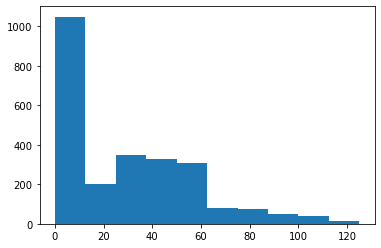

In [238]:
#number of positive samples
length = [len(dataset[cell]) for cell in dataset]
sorted_length = sorted(length,reverse=True)
plt.hist(length)

In [240]:
sorted_length[:11]

[125, 123, 123, 118, 117, 117, 116, 116, 115, 114, 114]

In [241]:
#keep cells with at least 40 positive samples
dataset_114 = {}
for cell in dataset:
    
    if len(dataset[cell]) >= 114 and len(dataset_114)<10:
        
        dataset_114[cell] = dataset[cell]
        
len(dataset_114)

10

In [242]:
#change type to float32

for cell in dataset_114:
    
    positive_32 = []
    for positive in dataset_114[cell]:
    
        positive_32.append(positive.astype(np.float32))
    dataset_114[cell] = positive_32

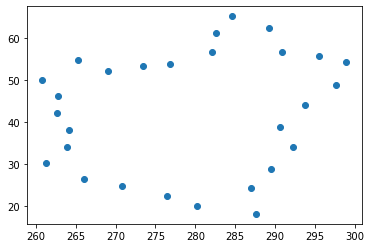

In [243]:
#Visualize control points
plt.figure()
points = dataset_114['17P1_POS0007_F_2UL_58'][0]
plt.scatter(points[:,0],points[:,1])
plt.show()

In [244]:
#add noisy version of control points

for cell in dataset_114:
    while len(dataset_114[cell])!=1000:
        noise = np.random.normal(0,1,dataset_114[cell][0].shape)
        perturbed_array = dataset_114[cell][0] + noise
        dataset_114[cell].append(perturbed_array)

In [245]:
#transform array of control points to distograms matrices

from scipy.spatial import distance_matrix

distograms = {}

for cell in dataset_114:
    
    positives = []
    for positive in dataset_114[cell]:
        
        dist = distance_matrix(positive,positive)
        max_, min_ = np.max(dist), np.min(dist)
        new_dist = (dist - min_)/(max_ - min_)
        positives.append(new_dist.astype(np.float32))
    distograms[cell] = positives

In [246]:
#create dataset class

class DistogramDataset(torch.utils.data.Dataset):
    
    def __init__(self,transform,train=True):
        
        self.data = []
        self.transform = transform
        
        label_ = 0
        dic_label = {}
    
            
        for cell in distograms:
            for positive in distograms[cell]:
                self.data.append((positive,label_))

            dic_label[cell] = label_
            label_+=1
            
        N = len(self.data)
        random.seed(10)
        random.shuffle(self.data)
        
        if train:
            self.data = self.data[:int(0.8*N)]
            
        else:
            self.data = self.data[int(0.8*N):]
            
                
    def __len__(self):
        
        return len(self.data)
    
    def __getitem__(self,idx):
        
        distogram = self.data[idx][0]
        label = self.data[idx][1]
        
        if self.transform:
            distogram = self.transform(distogram)
        
        return distogram, label

In [247]:
#Creating the dataloader
dataset_vae = DistogramDataset(transform=ToTensor())
dataloader = torch.utils.data.DataLoader(dataset_vae,batch_size=128, shuffle=True)

In [248]:
len(dataset_vae)

8000

In [249]:
next(iter(dataloader))

[tensor([[[[0.0000, 0.1450, 0.2403,  ..., 0.2784, 0.2367, 0.1414],
           [0.1450, 0.0000, 0.1271,  ..., 0.3419, 0.2724, 0.1627],
           [0.2403, 0.1271, 0.0000,  ..., 0.3245, 0.2440, 0.1678],
           ...,
           [0.2784, 0.3419, 0.3245,  ..., 0.0000, 0.0810, 0.1793],
           [0.2367, 0.2724, 0.2440,  ..., 0.0810, 0.0000, 0.1118],
           [0.1414, 0.1627, 0.1678,  ..., 0.1793, 0.1118, 0.0000]]],
 
 
         [[[0.0000, 0.0723, 0.1849,  ..., 0.2601, 0.1950, 0.0615],
           [0.0723, 0.0000, 0.1459,  ..., 0.2897, 0.2186, 0.1123],
           [0.1849, 0.1459, 0.0000,  ..., 0.2309, 0.1668, 0.1702],
           ...,
           [0.2601, 0.2897, 0.2309,  ..., 0.0000, 0.0718, 0.1992],
           [0.1950, 0.2186, 0.1668,  ..., 0.0718, 0.0000, 0.1363],
           [0.0615, 0.1123, 0.1702,  ..., 0.1992, 0.1363, 0.0000]]],
 
 
         [[[0.0000, 0.1180, 0.2073,  ..., 0.3375, 0.2454, 0.1287],
           [0.1180, 0.0000, 0.0894,  ..., 0.3787, 0.2996, 0.1808],
           [0.2073

**Simple Autoencoder**

In [250]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

**VAE**

In [251]:
#VAE Encoder class

class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]

class VAE(nn.Module):
    
    
    def __init__(self, latent_dims):
        super(VAE, self).__init__()
        
        
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(3136, latent_dims)
        self.z_log_var = torch.nn.Linear(3136, latent_dims)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(latent_dims, 3136),
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )
   
    def reparametrize(self,mu,log_var):
        
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        sample = mu + eps*std
        
        return sample
        
    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparametrize(z_mean, z_log_var)
        return encoded
        
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparametrize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [252]:
def final_loss(bce_loss, mu, log_var):
    
    BCE = bce_loss
    KL = -0.5*torch.sum(1 + log_var -mu.pow(2) - log_var.exp())
    return BCE + KL

In [253]:
criterion = nn.BCELoss(reduction='sum')
def train_VAE(model, data, epochs=20):
    optim = torch.optim.Adam(model.parameters(), lr=0.005)
    #scheduler = lr_scheduler.StepLR(optim,step_size=5,gamma=0.1)
    for epoch in range(epochs):
        
        running_loss = 0
        for x, y in data:
            x = x.to(device)
            optim.zero_grad()
            z, mu, log_var, x_hat = model(x)
            bce_loss = criterion(x_hat,x)
            loss = final_loss(bce_loss, mu, log_var)
            running_loss+=loss.item()
            loss.backward()
            optim.step()
            #scheduler.step()
        
        print("epochs = ", epoch, "loss = ", running_loss/len(data.dataset))
        print("-----------------------------------------------------------")
    return model

In [ ]:
vae_ = VAE(latent_dims=2).to(device)
vae_ = train_VAE(vae_, dataloader)

In [ ]:
def plot_latent(model, data, num_batches=61):
    for i, (x, y) in enumerate(dataloader):
        z,_,_,_ = model(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

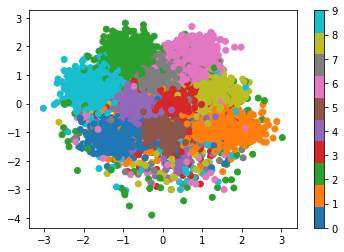

In [58]:
plot_latent(vae_,dataloader)

In [47]:
len(dataloader)

63

In [59]:
distograms['17P1_POS0007_F_2UL_58'][669]

array([[0.        , 0.14388584, 0.27825728, 0.3792764 , 0.42869022,
        0.52807015, 0.6704044 , 0.79879516, 0.82858837, 0.8811173 ,
        0.8289383 , 0.8873434 , 0.95415837, 0.8430133 , 0.82642305,
        0.80749834, 0.77385217, 0.6265524 , 0.6095055 , 0.511603  ,
        0.32014698, 0.396918  , 0.34659556, 0.14347702, 0.10861502,
        0.09422248, 0.03345122, 0.06957385],
       [0.14388584, 0.        , 0.13437173, 0.23577337, 0.2876322 ,
        0.38428232, 0.52859896, 0.6567168 , 0.6851264 , 0.7404576 ,
        0.69547856, 0.7592371 , 0.8402021 , 0.7311098 , 0.73056716,
        0.73012155, 0.7193859 , 0.5782794 , 0.5444954 , 0.4633699 ,
        0.31005445, 0.43452612, 0.41362232, 0.19327338, 0.19192934,
        0.19708623, 0.16900346, 0.1782882 ],
       [0.27825728, 0.13437173, 0.        , 0.10265021, 0.16066775,
        0.25013041, 0.39762107, 0.5250078 , 0.55131036, 0.6103513 ,
        0.5752101 , 0.64541006, 0.7429342 , 0.637989  , 0.65673053,
        0.6773929 , 0.6916

In [59]:
#distogram to images
!git clone https://github.com/ctr26/mask-vae.git

fatal: destination path 'mask-vae' already exists and is not an empty directory.


In [63]:
sys.path.append("mask-vae")

In [73]:
from train_distograms import DistogramtoImage

In [74]:
cl = DistogramtoImage()

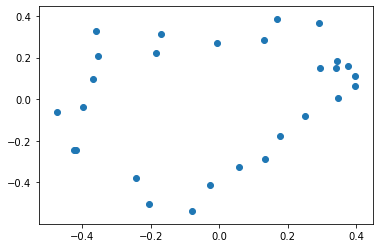

In [77]:
p = cl.get_points_from_dist(distograms['17P1_POS0007_F_2UL_58'][669])
plt.scatter(p[:,0],p[:,1])

In [78]:
!git clone -b virginies-playground https://gitlab.ebi.ac.uk/uhlmann-group/python-spline-fitting-toolbox.git

Cloning into 'python-spline-fitting-toolbox'...


In [82]:
from splineCurveModels import SplineCurve

In [178]:
#make the distogram symmetric
def make_symmetric(tensor):
    
    n = tensor.shape[0]
    for i in range(n):
        for j in range(i):
            tensor[i,j] = tensor[j,i]
            
    return tensor

In [230]:
def interpolate(model, x_1, x_2, n=12):
    z_1,_,_,_ = model(x_1.to(device))
    z_2,_,_,_ = model(x_2.to(device))
    
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = model.decoder(z)

    interpolate_list = [make_symmetric(interpolate_list[i,:,:,:].squeeze()) for i in range(n)]
    curve_interpolate = [cl.get_points_from_dist(interpolate_list[i].detach().numpy()) for i in range(n)]
    #interpolate_list = interpolate_list.to('cpu').detach().numpy()
    #curve_interpolate = curve_interpolate.to("cpu").detach().numpy()
    
    for i in range(n):
        
        plt.figure()
        plt.plot(curve_interpolate[i][:,0],curve_interpolate[i][:,1])
        plt.show()

In [231]:
x, y = dataloader.__iter__().next()

In [232]:
x_1 = x[y == 1][1].to(device)
x_2 = x[y == 0][1].to(device) 
print(x_1.shape)

x_1 = torch.reshape(x_1,(1,1,28,28))
x_2 = torch.reshape(x_2,(1,1,28,28))

torch.Size([1, 28, 28])


In [233]:
coeff_1 = cl.get_points_from_dist(torch.reshape(x_1,(28,28)))
coeff_2 = cl.get_points_from_dist(torch.reshape(x_2,(28,28)))

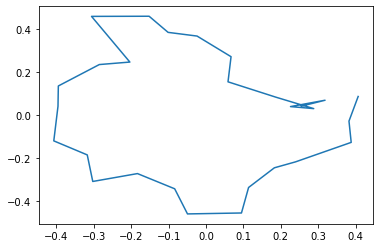

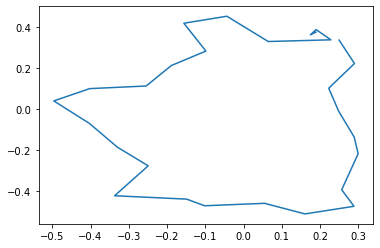

In [234]:
#curve1

plt.figure()
plt.plot(coeff_1[:,0],coeff_1[:,1])
plt.show()

plt.figure()
plt.plot(coeff_2[:,0],coeff_2[:,1])
plt.show()

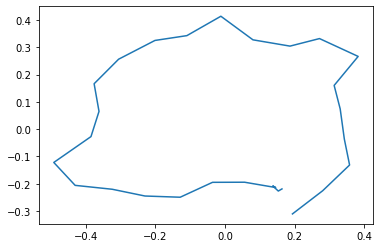

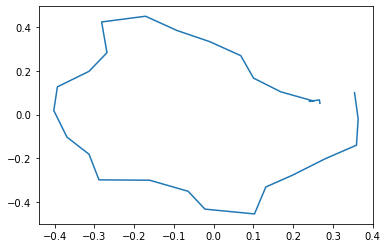

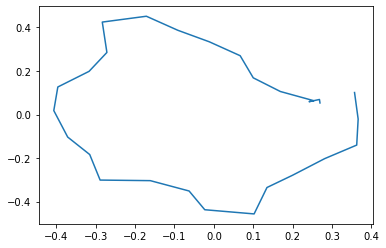

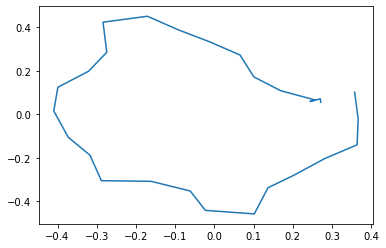

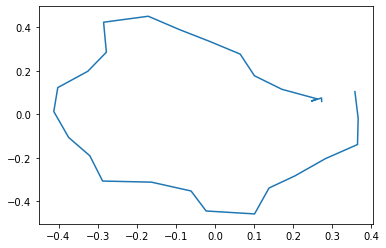

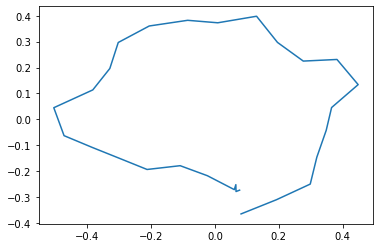

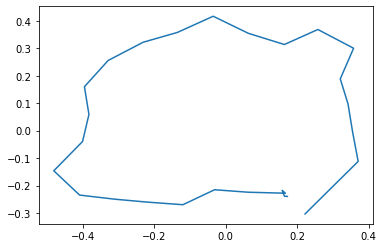

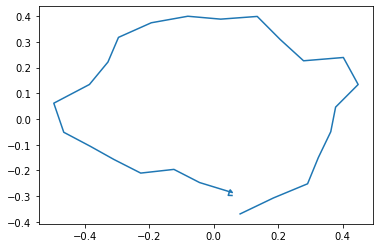

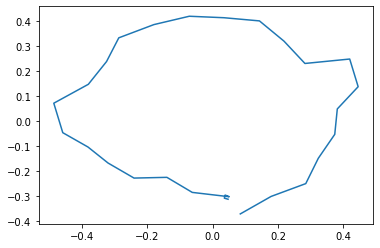

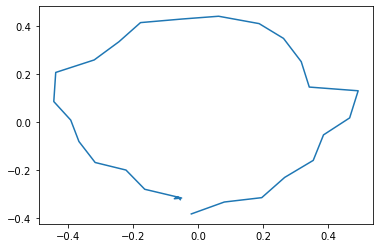

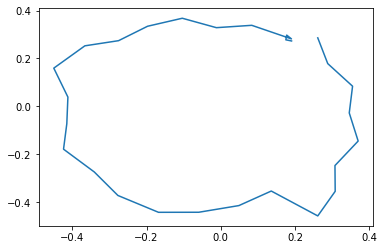

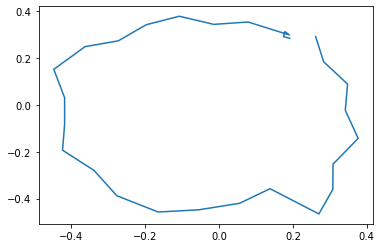

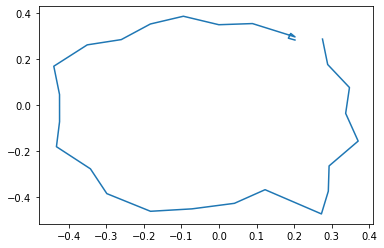

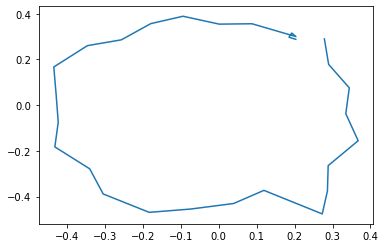

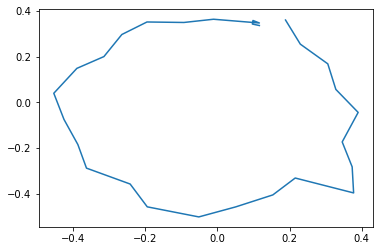

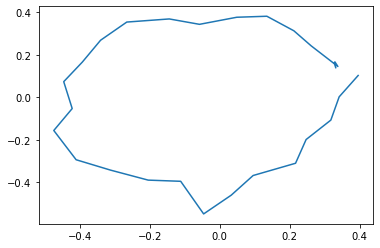

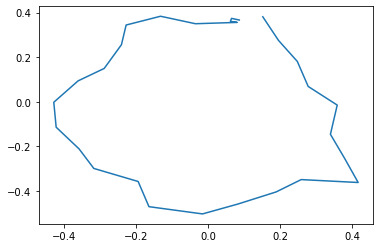

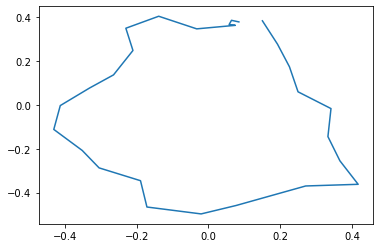

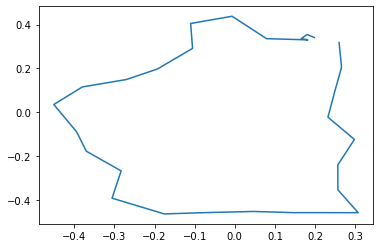

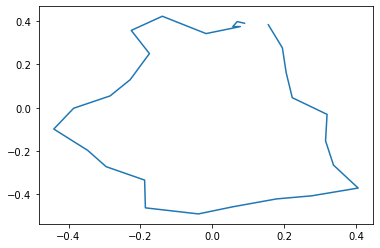

In [235]:
z = interpolate(vae_, x_1, x_2, n=20)

In [158]:
z.shape

torch.Size([20, 1, 28, 28])

In [173]:
array = z[0,:,:,:].squeeze()

In [174]:
array.shape

torch.Size([28, 28])

In [176]:

for i in range(28):
    for j in range(i):
        
        array[i,j] = array[j,i]

In [177]:
array

tensor([[1.5742e-03, 1.2595e-01, 2.2963e-01, 3.3766e-01, 4.2969e-01, 5.0494e-01,
         5.8169e-01, 6.3426e-01, 5.9185e-01, 6.4461e-01, 7.0377e-01, 6.9718e-01,
         7.1246e-01, 6.9092e-01, 6.9400e-01, 6.2879e-01, 6.2832e-01, 6.8227e-01,
         6.2291e-01, 5.3713e-01, 4.3298e-01, 3.5248e-01, 2.6553e-01, 1.7292e-01,
         1.0231e-01, 1.2196e-01, 1.1562e-01, 1.1054e-01],
        [1.2595e-01, 9.5913e-04, 1.2372e-01, 2.1497e-01, 3.0549e-01, 3.6579e-01,
         4.8442e-01, 5.5430e-01, 5.2221e-01, 5.6565e-01, 6.8675e-01, 6.5761e-01,
         7.0301e-01, 7.0660e-01, 6.8595e-01, 6.2982e-01, 6.4586e-01, 7.2533e-01,
         7.0811e-01, 6.3660e-01, 5.0537e-01, 4.0847e-01, 3.1496e-01, 2.3787e-01,
         1.3835e-01, 1.4654e-01, 1.3480e-01, 1.4836e-01],
        [2.2963e-01, 1.2372e-01, 3.3560e-05, 1.0620e-01, 2.2034e-01, 2.7827e-01,
         3.8860e-01, 4.4169e-01, 4.8117e-01, 5.3349e-01, 6.1896e-01, 6.2429e-01,
         6.7917e-01, 7.3488e-01, 7.1012e-01, 6.6793e-01, 7.3844e-01, 8.759